In [1]:
# Import Libraries
import numpy as np
import tensorflow.compat.v1 as tf # We have to load the older version of tensorflow
from FBSNNs import FBSNN
import matplotlib.pyplot as plt
%matplotlib inline
tf.compat.v1.disable_eager_execution()
import time


In this code, we solve the following FBSDE:
\begin{align}
    dX_t &= -\rho_r(X-\mu_r)dt + \sigma_r dW_t \\
    dY_t &= \frac{1}{\sigma}(max\{X,0\}-X)dt + Z_t \sigma_r dW_t
\end{align}
with $Y_T = 0$ and $X_0 = \mu_r$

Clearly, $X_t$ is the forward process and $Y_t$ the backward process. To map to our problem $(X_t,Y_t) = (r_t,x_t)$, where here we are imposing the interest rate rule $i_t:= max\{r,0\}$.

As explained in Raissi's writeup (https://maziarraissi.github.io/FBSNNs/), the neural network approximates a solutionn to the quasi-linear PDE
$$ u_t = f(t,x,u,Du,D^2u)$$
with the properties
\begin{align}
Y_t &= u(t,X_t) \\
Z_t &= Du(t,X_t)
\end{align}
Hence the solution will allow us to recover the components of the backward SDE for any given draw of time steps and Brownian innovations.

In [2]:
# Define Parameters
beta = 0.02
alpha_i = 1
sigma = 1
rho_r = 1
mu_r = 0.02
sigma_r = 1

In [3]:
start = time.time()

class FirstZLB(FBSNN):
    def __init__(self, Xi, T,
                       M, N, D,
                       layers):
        
        super().__init__(Xi, T,
                         M, N, D,
                         layers)
    
    
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        """Drift Term, BSDE"""
        return (1/sigma)*(tf.maximum(X,0)-X) # M x 1
    
    def g_tf(self, X): # M x D
        """Terminal Condition, BSDE"""
        return 0*tf.reduce_sum(X**2, 1, keepdims = True) # M x 1

    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        """Drift Term, FSDE"""
        return -rho_r*(X-mu_r) # M x D
    
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        """Diffusion, FSDE"""
        return sigma_r*super().sigma_tf(t, X, Y) # M x D x D

    
    
    ###########################################################################


if __name__ == "__main__":
    
    M = 100 # number of trajectories (batch size)
    N = 50 # number of time snapshots
    D = 1 # number of dimensions
    
    layers = [D+1] + 4*[256] + [1]

    Xi = mu_r*np.ones([1,D]) # Initial Condition, FSDE
    T = 1.0
         
    # Training
    model = FirstZLB(Xi, T,
                                  M, N, D,
                                  layers)
        
    model.train(N_Iter = 2*10**4, learning_rate=1e-3)
    model.train(N_Iter = 3*10**4, learning_rate=1e-4)
    model.train(N_Iter = 3*10**4, learning_rate=1e-5)
    model.train(N_Iter = 2*10**4, learning_rate=1e-6)
    
    
end = time.time()

print(end-start)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device

It: 0, Loss: 2.398e+03, Y0: 0.064, Time: 3.93, Learning Rate: 1.000e-03
It: 10, Loss: 8.559e+01, Y0: -0.018, Time: 0.83, Learning Rate: 1.000e-03
It: 20, Loss: 8.757e+00, Y0: 0.047, Time: 0.81, Learning Rate: 1.000e-03
It: 30, Loss: 8.473e+00, Y0: -0.018, Time: 0.81, Learning Rate: 1.000e-03
It: 40, Loss: 1.588e+00, Y0: 0.012, Time: 0.81, Learning Rate: 1.000e-03
It: 50, Loss: 2.182e-01, Y0: -0.002, Time: 0.81, Learning Rate: 1.000e-03
It: 60, Loss: 5.790e-01, Y0: -0.003, Time: 0.81, Learning Rate: 1.000e-03
It: 70, Loss: 4.130e-01, Y0: -0.005, Time: 0.81, Learning Rate: 1.000e-03
It: 80, Loss: 3.241e-01, Y0: -0.010, Time: 0.82, Learning Rate: 1.000e-03
It: 90, Loss: 2.801e-01, Y0: -0.013, Time: 0.95, Learning Rate: 1.000e-03
It: 100, Loss: 1.868e-01, Y0: -0.017, Time: 0.95, Learning Rate: 1.000e-03
It: 110, Loss: 2.395e-01, Y0: -0.021, Time: 0.92, Learning Rate: 1.000e-03
It: 120, Loss: 2.008e-

In [4]:
# Predict
t_test, W_test = model.fetch_minibatch() # Simulate time periods, Brownian motions
X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test) # Construct Associated X, Y, Z Termss



Text(0.5, 1.0, '3 Paths of Z_t')

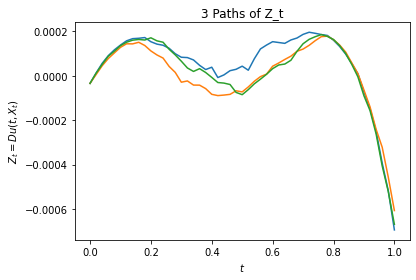

In [15]:
# Plot Three Paths of Z_t 
for i in range(3):
    plt.plot(np.transpose(t_test[0:1,:,0]),Z_pred[i,:,:])
plt.xlabel('$t$')
plt.ylabel('$Z_t = Du(t,X_t)$')
plt.title("3 Paths of Z_t")


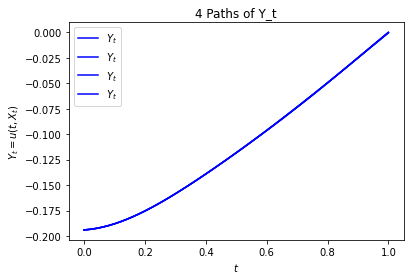

In [18]:
# Plot Paths of BSDE
plt.figure()
plt.plot(t_test[1:5,:,0].T,Y_pred[1:5,:,0].T,'b',label='$Y_t$')
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title('4 Paths of Y_t')
plt.legend()
